# Airport Traffic Delays
September 2016 <br>
Author: Peter Corniotes

### Loading Datasets and Organizing Data

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster import hierarchy
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from math import sin, cos, sqrt, atan2, radians
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 80)
%matplotlib inline

In [2]:
# load 3 datasets
df1 = pd.read_csv('/Users/petercorniotes/Downloads/airports.csv')
df2 = pd.read_csv('/Users/petercorniotes/Downloads/airport_operations.csv')
df3 = pd.read_csv('/Users/petercorniotes/Downloads/airport_cancellations.csv')
df1.head(2)

,Key,LocID,AP_NAME,ALIAS,Facility Type,FAA REGION,COUNTY,CITY,STATE,AP Type,Latitude,Longitude,Boundary Data Available
0,3443.0,STX,HENRY E ROHLSEN,Henry E Rohlsen Int'l Airport,Airport,ASO,-VIRGIN ISLANDS-,CHRISTIANSTED,VI,Public Use,17.701556,-64.801722,Yes
1,5088.0,X64,PATILLAS,NaN,Airport,ASO,#NAME?,PATILLAS,PR,Public Use,17.982189,-66.019330,No


In [3]:
# delete certain columns in first dataframe
del df1['Key']; del df1['AP_NAME']; del df1['Facility Type']; del df1['FAA REGION'] 
del df1['COUNTY']; del df1['AP Type']; del df1['Boundary Data Available']

# rename columns in first dataframe
df1.columns = ['Airport', 'Name', 'City', 'State', 'Latitude', 'Longitude'] 

print 'df1 shape', df1.shape
df1.head(2)

df1 shape (5167, 6)


,Airport,Name,City,State,Latitude,Longitude
0,STX,Henry E Rohlsen Int'l Airport,CHRISTIANSTED,VI,17.701556,-64.801722
1,X64,NaN,PATILLAS,PR,17.982189,-66.019330


In [4]:
#combine latitude and longitude into a tuple
coordinates = []
lats = df1['Latitude'].tolist()
longs = df1['Longitude'].tolist()
for i in range(len(lats)):
    tupleEx = (lats[i], longs[i])
    coordinates.append(tupleEx)
df1['Coordinates'] = coordinates
df1.head()

,Airport,Name,City,State,Latitude,Longitude,Coordinates
0,STX,Henry E Rohlsen Int'l Airport,CHRISTIANSTED,VI,17.701556,-64.801722,"(17.701556, -64.801722)"
1,X64,NaN,PATILLAS,PR,17.982189,-66.019330,"(17.982189, -66.01933)"
2,PSE,Aeropuerto Mercedita,PONCE,PR,18.008306,-66.563028,"(18.008306, -66.563028)"
3,VQS,Aeropuerto Antonio Rivera Rodr�guez,ISLA DE VIEQUES,PR,18.134811,-65.493617,"(18.134811, -65.493617)"
4,X63,Aeropuerto Regional De Humacao,HUMACAO,PR,18.138017,-65.800718,"(18.138017, -65.800718)"


In [5]:
#check coordinates, then delete latitude and longitude columns
del df1['Latitude']; del df1['Longitude']  

In [6]:
print 'df2 shape', df2.shape
df2.head(2)

df2 shape (841, 15)


,airport,year,departures for metric computation,arrivals for metric computation,percent on-time gate departures,percent on-time airport departures,percent on-time gate arrivals,average_gate_departure_delay,average_taxi_out_time,average taxi out delay,average airport departure delay,average airborne delay,average taxi in delay,average block delay,average gate arrival delay
0,ABQ,2004,53971,53818,0.803,0.7809,0.7921,10.38,9.89,2.43,12.1,2.46,0.83,2.55,10.87
1,ABQ,2005,51829,51877,0.814,0.7922,0.8001,9.60,9.79,2.29,11.2,2.26,0.89,2.34,10.24


In [7]:
#rename columns in 2nd dataframe
df2.columns = ['Airport', 'Year', 'Num_Departures', 'Num_Arrivals', 
               'Gate_Departures_Percent_on_Time', 'Airport_Departures_Percent_on_Time', 
               'Gate_Arrivals_Percent_on_Time', 'Avg_Delay_Gate_Departures', 
               'Avg_Taxi_Out_Time', 'Avg_Taxi_Out_Delay', 'Avg_Departure_Delay', 
               'Avg_Airborne_Delay', 'Avg_Taxi_in_Delay', 'Avg_Block_Delay', 
               'Avg_Gate_Arrival_Delay']

#keep only most recent year of data
df2 = df2.loc[df2['Year'] == 2014]  

df2.head(2)

,Airport,Year,Num_Departures,Num_Arrivals,Gate_Departures_Percent_on_Time,Airport_Departures_Percent_on_Time,Gate_Arrivals_Percent_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay
10,ABQ,2014,33292,33137,0.7451,0.7148,0.732,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,ANC,2014,71099,66704,0.8288,0.8074,0.860,11.33,11.33,1.33,12.34,4.09,0.54,4.57,10.82


In [8]:
# replace on-time percentages with not on time percentges
df2.insert(4, 'Gate_Departures_%_Not_on_Time', 1 - df2.Gate_Departures_Percent_on_Time)
del df2['Gate_Departures_Percent_on_Time']
df2.insert(5, 'Airport_Departures_%_Not_on_Time',1 - df2.Airport_Departures_Percent_on_Time)
del df2['Airport_Departures_Percent_on_Time']
df2.insert(6, 'Gate_Arrivals_%_Not_on_Time', 1 - df2.Gate_Arrivals_Percent_on_Time)
del df2['Gate_Arrivals_Percent_on_Time']
df2.head()

,Airport,Year,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay
10,ABQ,2014,33292,33137,0.2549,0.2852,0.2680,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72
21,ANC,2014,71099,66704,0.1712,0.1926,0.1400,11.33,11.33,1.33,12.34,4.09,0.54,4.57,10.82
32,ATL,2014,428954,428312,0.2101,0.2866,0.1877,11.99,17.40,4.92,15.93,2.74,2.77,3.21,12.42
43,AUS,2014,60588,60264,0.2373,0.2618,0.2778,14.16,11.76,2.06,15.59,2.25,1.08,2.88,16.20
54,BDL,2014,39279,39109,0.2047,0.2395,0.2431,12.64,12.76,2.58,14.39,2.34,0.95,2.64,14.79


In [9]:
print 'df3 shape', df3.shape
df3.head(2)

df3 shape (805, 6)


,Airport,Year,Departure Cancellations,Arrival Cancellations,Departure Diversions,Arrival Diversions
0,ABQ,2004.0,242.0,235.0,71.0,46.0
1,ABQ,2005.0,221.0,190.0,61.0,33.0


In [10]:
#rename columns in 3rd dataframe
df3.columns = ['Airport', 'Year', 'Departure_Cancellations', 'Arrival_Cancellations', 
               'Departure_Diversions', 'Arrival_Diversions'] 

#keep only latest year of data
df3 = df3.loc[df3['Year'] == 2014.0] 

df3.head(2)

,Airport,Year,Departure_Cancellations,Arrival_Cancellations,Departure_Diversions,Arrival_Diversions
10,ABQ,2014.0,315.0,274.0,66.0,37.0
21,ANC,2014.0,111.0,162.0,74.0,28.0


In [11]:
#merge 2nd and 3rd dataframes
df4 = pd.merge(df2, df3, on='Airport')
del df4['Year_x']
del df4['Year_y']

#divide cancellations and diversions by size of airport
df4.insert(15, 'Cancellations_Departures', df4.Departure_Cancellations /\
           df4.Num_Departures)
del df4['Departure_Cancellations']
df4.insert(16, 'Cancellations_Arrivals', df4.Arrival_Cancellations /\
           df4.Num_Arrivals)
del df4['Arrival_Cancellations']
df4.insert(17, 'Diversions_Departures', df4.Departure_Diversions /\
           df4.Num_Departures)
del df4['Departure_Diversions']
df4.insert(18, 'Diversions_Arrivals', df4.Arrival_Diversions /\
           df4.Num_Arrivals)
del df4['Arrival_Diversions']

print 'df4 shape', df4.shape
df4.head(3)

df4 shape (72, 18)


,Airport,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,ABQ,33292,33137,0.2549,0.2852,0.2680,14.30,10.64,2.41,15.99,1.73,1.02,2.40,14.72,0.009462,0.008269,0.001982,0.001117
1,ANC,71099,66704,0.1712,0.1926,0.1400,11.33,11.33,1.33,12.34,4.09,0.54,4.57,10.82,0.001561,0.002429,0.001041,0.000420
2,ATL,428954,428312,0.2101,0.2866,0.1877,11.99,17.40,4.92,15.93,2.74,2.77,3.21,12.42,0.013934,0.015136,0.001821,0.001529


In [12]:
#merge remaining dataframes
df5 = pd.merge(df1, df4, on='Airport')
print 'df5 shape', df5.shape
df5.head()

df5 shape (72, 22)


,Airport,Name,City,State,Coordinates,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,SJU,Aeropuerto Int'l Luis Mu�oz Marin,SAN JUAN,PR,"(18.439295, -66.002004)",43671,42965,0.1944,0.2216,0.2185,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,0.006412,0.005609,0.001649,0.000722
1,OGG,Kahului Airport,KAHULUI,HI,"(20.89865, -156.430458)",34163,33547,0.0993,0.1119,0.1216,5.80,8.58,1.39,6.44,1.71,0.87,3.85,7.18,0.003337,0.002534,0.000995,0.001043
2,HNL,Honolulu Int'l Airport,HONOLULU,HI,"(21.318681, -157.922429)",90752,88621,0.1118,0.1400,0.1423,6.45,13.52,2.31,7.84,1.91,1.17,3.50,8.22,0.001972,0.001873,0.000705,0.000880
3,MIA,Miami Int'l Airport,MIAMI,FL,"(25.795361, -80.290111)",168629,164346,0.2217,0.2828,0.2175,14.23,17.11,4.28,17.44,2.80,2.40,3.81,14.61,0.004952,0.005768,0.001678,0.002051
4,FLL,Ft Lauderdale/Hollywood Int'l Arpt,FORT LAUDERDALE,FL,"(26.072596, -80.152741)",106272,105742,0.2710,0.3201,0.2566,16.55,15.94,3.58,19.36,2.43,1.21,3.88,15.53,0.008234,0.008455,0.001938,0.001485


In [13]:
# add a new column for airport shortname
shortname = ['SJU-SJuan', 'OGG-Maui', 'HNL-Honlu', 'MIA-Dade', 'FLL-FtLaud', 'RSW-FtMyers', 
             'PBI-WPalmB', 'TPA-Tampa', 'MCO-Orlando', 'SAT-SanAntno', 'HOU-Hobby', 
             'IAH-HoustonBush', 'MSY-NewOrleans', 'AUS-Austin', 'JAX-Fl', 'TUS-Az', 
             'SAN-SDiego', 'DAL-Love', 'DFW-DFtWrth', 'PHX', 'BHM-Al', 'ATL', 'SNA-SantaAna', 
             'LGB-Ca', 'PSP-PalmSpr', 'LAX', 'ONT-Ca', 'BUR-Burbank', 'ABQ-Albuq', 
             'MEM-Memphis', 'CLT-Charlt', 'RDU-Raleigh', 'LAS-Vegas', 'BNA-Nashvl', 
             'SJC-SanJose', 'SFO', 'OAK', 'SDF-Louisvll', 'SMF-Sac', 'STL', 'DCA', 
             'IAD-WaDulles', 'CVG-Ky', 'BWI-Balt', 'MCI-KSCity', 'IND', 'DEN', 'PHL', 
             'DAY-Ohio', 'PIT', 'JFK', 'EWR', 'LGA', 'SLC-SaltL', 'ISP-LiNy', 'HPN-WchNy', 
             'OMA-Omaha', 'CLE', 'SWF-OrangeNY', 'PVD-Ri', 'MDW-Chi', 'BDL-Htfd', 'ORD-Ohare', 
             'DTW-Det', 'BOS', 'MHT-Nh', 'BUF', 'MKE-Milw', 'MSP-Mn', 'PDX-PortOr', 'SEA', 
             'ANC-Anchorage']
df5.insert(0, 'shortname', shortname) 
df5

,shortname,Airport,Name,City,State,Coordinates,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,SJU-SJuan,SJU,Aeropuerto Int'l Luis Mu�oz Marin,SAN JUAN,PR,"(18.439295, -66.002004)",43671,42965,0.1944,0.2216,0.2185,11.71,12.89,1.88,13.13,1.81,1.00,2.93,12.79,0.006412,0.005609,0.001649,0.000722
1,OGG-Maui,OGG,Kahului Airport,KAHULUI,HI,"(20.89865, -156.430458)",34163,33547,0.0993,0.1119,0.1216,5.80,8.58,1.39,6.44,1.71,0.87,3.85,7.18,0.003337,0.002534,0.000995,0.001043
2,HNL-Honlu,HNL,Honolulu Int'l Airport,HONOLULU,HI,"(21.318681, -157.922429)",90752,88621,0.1118,0.1400,0.1423,6.45,13.52,2.31,7.84,1.91,1.17,3.50,8.22,0.001972,0.001873,0.000705,0.000880
3,MIA-Dade,MIA,Miami Int'l Airport,MIAMI,FL,"(25.795361, -80.290111)",168629,164346,0.2217,0.2828,0.2175,14.23,17.11,4.28,17.44,2.80,2.40,3.81,14.61,0.004952,0.005768,0.001678,0.002051
4,FLL-FtLaud,FLL,Ft Lauderdale/Hollywood Int'l Arpt,FORT LAUDERDALE,FL,"(26.072596, -80.152741)",106272,105742,0.2710,0.3201,0.2566,16.55,15.94,3.58,19.36,2.43,1.21,3.88,15.53,0.008234,0.008455,0.001938,0.001485
5,RSW-FtMyers,RSW,Southwest Florida Int'l Airport,FORT MYERS,FL,"(26.536167, -81.755167)",34687,34572,0.2184,0.2475,0.2442,13.91,12.31,2.45,15.67,2.61,1.02,3.93,14.58,0.011070,0.010124,0.002652,0.002372
6,PBI-WPalmB,PBI,Palm Beach Int'l Airport,WEST PALM BEACH,FL,"(26.683167, -80.095583)",37466,36904,0.3414,0.3703,0.3561,18.58,13.11,2.21,20.42,2.93,0.78,5.03,20.17,0.011450,0.011218,0.002349,0.001517
7,TPA-Tampa,TPA,Tampa Int'l Airport,TAMPA,FL,"(27.975472, -82.53325)",79489,79173,0.2274,0.2546,0.2464,14.33,12.00,2.39,15.97,2.24,0.88,3.53,14.87,0.009096,0.008728,0.002302,0.002059
8,MCO-Orlando,MCO,Orlando Int'l Airport,ORLANDO,FL,"(28.429394, -81.308993)",139833,139627,0.2452,0.2904,0.2429,15.69,13.81,3.69,18.46,2.13,2.16,3.91,15.16,0.008932,0.008960,0.002460,0.002227
9,SAT-SanAntno,SAT,San Antonio Int'l Airport,SAN ANTONIO,TX,"(29.533694, -98.469778)",53144,53325,0.2399,0.2644,0.2677,13.55,11.07,2.07,14.86,2.17,1.02,2.84,15.20,0.008618,0.007295,0.001505,0.001575


### Hierarchical Clustering

##### Distance Matrix

In [14]:
# function for measuring distance between 2 locations (source: stackoverflow)
def distance_between(lat_long_1, lat_long_2):
    R = 6373.0
    lat1 = radians(lat_long_1[0])
    lon1 = radians(lat_long_1[1])
    lat2 = radians(lat_long_2[0])
    lon2 = radians(lat_long_2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance   

#matrix of distances
airp_ix = df5['shortname']
coordinates = df5['Coordinates']
df6 = pd.DataFrame(index=airp_ix, columns=['temporary_col'])
del df6['temporary_col']
num_airports = df5.shape[0]
for i in range(num_airports):
    distances = []
    short_name = airp_ix[i]
    for j in range(num_airports):
        distance = distance_between(coordinates[i], coordinates[j])
        distances.append(distance)
    s = pd.Series(distances, index=airp_ix)
    df6[short_name] = s
print 'df6 shape', df6.shape
df6

df6 shape (72, 72)


,SJU-SJuan,OGG-Maui,HNL-Honlu,MIA-Dade,FLL-FtLaud,RSW-FtMyers,PBI-WPalmB,TPA-Tampa,MCO-Orlando,SAT-SanAntno,HOU-Hobby,IAH-HoustonBush,MSY-NewOrleans,AUS-Austin,JAX-Fl,TUS-Az,SAN-SDiego,DAL-Love,DFW-DFtWrth,PHX,BHM-Al,ATL,SNA-SantaAna,LGB-Ca,PSP-PalmSpr,LAX,ONT-Ca,BUR-Burbank,ABQ-Albuq,MEM-Memphis,CLT-Charlt,RDU-Raleigh,LAS-Vegas,BNA-Nashvl,SJC-SanJose,SFO,OAK,SDF-Louisvll,SMF-Sac,STL,DCA,IAD-WaDulles,CVG-Ky,BWI-Balt,MCI-KSCity,IND,DEN,PHL,DAY-Ohio,PIT,JFK,EWR,LGA,SLC-SaltL,ISP-LiNy,HPN-WchNy,OMA-Omaha,CLE,SWF-OrangeNY,PVD-Ri,MDW-Chi,BDL-Htfd,ORD-Ohare,DTW-Det,BOS,MHT-Nh,BUF,MKE-Milw,MSP-Mn,PDX-PortOr,SEA,ANC-Anchorage
shortname,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SJU-SJuan,0.000000,9332.581383,9465.915777,1682.596370,1684.236498,1850.180437,1711.569332,1991.930532,1913.920948,3507.926725,3212.485662,3228.937016,2767.220184,3450.922245,2074.118253,4730.704121,5321.248599,3465.165217,3483.406073,4850.078237,2661.060030,2491.700745,5392.438894,5419.865653,5268.600428,5444.582401,5371.534143,5442.423100,4397.057391,2999.111483,2377.383315,2310.787846,5177.443023,2824.493077,5794.327113,5836.058291,5823.564772,2911.246910,5779.827824,3260.964086,2508.259470,2535.126163,2914.348966,2525.304578,3605.377965,3065.316963,4397.280079,2543.630827,2958.386938,2804.847681,2578.731631,2595.219416,2595.767861,5017.206127,2577.309944,2621.782499,3809.249598,2965.906997,2678.525746,2640.638753,3314.656769,2689.452245,3339.077076,3111.353971,2702.712679,2771.996810,2976.711067,3415.190161,3873.114558,5977.538951,5997.905966,7901.499219
OGG-Maui,9332.581383,0.000000,161.711079,7686.144918,7692.114567,7524.728372,7681.559870,7414.696732,7521.179807,5853.355304,6159.428194,6149.518930,6635.534842,5924.234766,7437.693336,4660.222918,4084.775238,5981.873241,5964.211349,4573.330382,6909.986876,7121.963867,4040.073189,4017.252358,4167.039376,3996.700779,4072.145950,4006.864997,5084.285873,6597.172452,7408.676140,7588.069511,4334.488974,6881.956762,3789.098783,3761.562070,3778.203971,6940.868179,3867.417189,6533.709077,7679.464199,7641.599015,7023.287522,7704.274634,6157.153740,6877.139758,5309.987030,7809.944845,7051.838185,7380.240722,7914.618762,7881.228672,7903.780609,4721.059557,7967.022620,7910.855899,6062.472602,7232.210284,7868.649039,8081.215480,6739.955443,7974.479471,6726.243565,7099.471968,8099.351562,8051.167666,7466.442736,6723.046776,6298.636875,4123.595517,4249.596152,4507.710573
HNL-Honlu,9465.915777,161.711079,0.000000,7814.347016,7819.765966,7652.185166,7808.086263,7539.781385,7644.935774,5979.778022,6284.981927,6274.359164,6759.138697,6049.062062,7557.550896,4780.819843,4202.007628,6100.512568,6082.756601,4689.969522,7024.996525,7236.155836,4153.969828,4130.543105,4281.035884,4109.446884,4184.914583,4118.770055,5197.343525,6709.568544,7518.302688,7695.478047,4441.808271,6991.129052,3887.037936,3858.081807,3874.493573,7044.968456,3960.675344,6637.162117,7779.488314,7741.548834,7125.038018,7803.414260,6259.478510,6977.568256,5409.550426,7906.932719,7151.403040,7477.384768,8009.242422,7975.879374,7998.116496,4814.657020,8061.010090,8004.441940,6159.350436,7327.515422,7961.346441,8172.317596,6835.330536,8065.585336,6821.125217,7193.079424,8188.754341,8139.382211,7557.136339,6815.387670,6385.699865,4189.575252,4309.180974,4475.591696
MIA-Dade,1682.596370,7686.144918,7814.347016,0.000000,33.759765,167.870412,100.639506,329.109900,309.857911,1836.436178,1535.359017,1549.857444,1084.866809,1773.557570,540.297001,3053.703470,3643.622871,1784.449561,1802.657925,3169.175287,1065.532529,959.155604,3712.143765,3739.283835,3587.753539,3763.766494,3690.391384,3761.108198,2715.367309,1384.497259,1049.497763,1130.546395,3495.204398,1299.633728,4112.829761,4154.923968,4142.637145,1468.857797,4101.386389,1722.058514,1483.802308,1486.636608,1529.857563,1526.171797,2015.654188,1646.167028,2749.446703,1634.551727,1611.011751,1634.654562,1757.423450,1750.902549,1768.693417,3358.378882,1795.676832,1803.760244,2243.652607,

##### Dendrogram

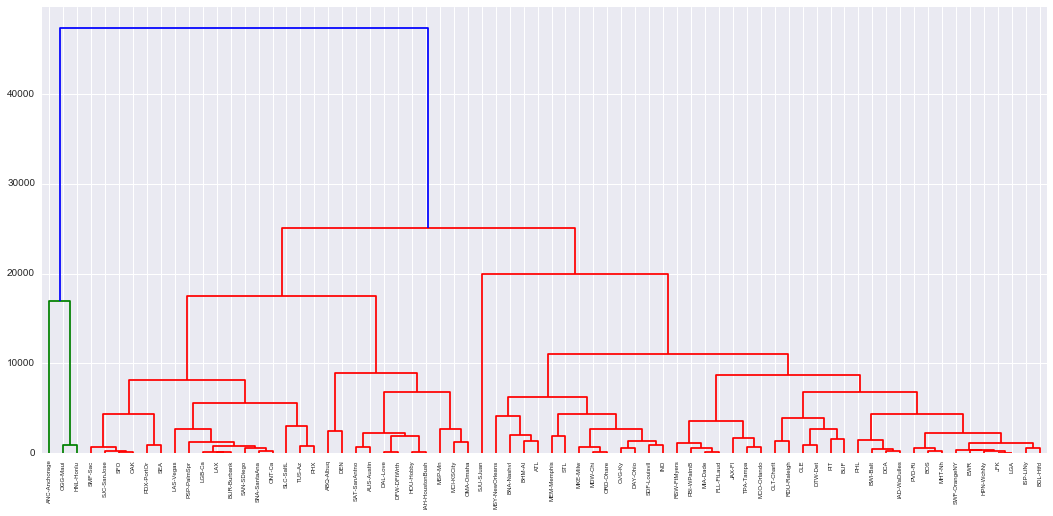

In [15]:
Z = hierarchy.linkage(df6, 'complete')
fig, ax = plt.subplots(figsize=(18,8))
matplotlib.rcParams.update({'font.size': 22})
dn = hierarchy.dendrogram(Z, labels=df6.index)

In [16]:
#assign geo_clusters
geo_cluster = ['L','A','A','H','H','H','H','H','H','E','E','E','F','E','H','C','C','E','E','C',
               'F','F','C','C','C','C','C','C','D','G','K','K','C','F','B','B','B','G','B','G',
               'J','J','G','J','E','G','D','J','G','K','I','I','I','C','I','I','E','K','I','I',
               'G','I','G','K','I','I','K','G','E','B','B','A']
len(geo_cluster)

72

### Principal Component Analysis

##### Cumulative Explained Variance

In [17]:
#view dataframe
df5.head(1)

,shortname,Airport,Name,City,State,Coordinates,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,SJU-SJuan,SJU,Aeropuerto Int'l Luis Mu�oz Marin,SAN JUAN,PR,"(18.439295, -66.002004)",43671,42965,0.1944,0.2216,0.2185,11.71,12.89,1.88,13.13,1.81,1.0,2.93,12.79,0.006412,0.005609,0.001649,0.000722


In [18]:
#begin by scaling features
#select all numerical data except coordinates
x = df5.ix[:,6:].values

#check that the correct feature columns for scaling were selected
x

array([[  4.36710000e+04,   4.29650000e+04,   1.94400000e-01, ...,
          5.60921680e-03,   1.64869135e-03,   7.21517514e-04],
       [  3.41630000e+04,   3.35470000e+04,   9.93000000e-02, ...,
          2.53375861e-03,   9.95228756e-04,   1.04331237e-03],
       [  9.07520000e+04,   8.86210000e+04,   1.11800000e-01, ...,
          1.87314519e-03,   7.05218618e-04,   8.80152560e-04],
       ..., 
       [  9.48280000e+04,   9.47020000e+04,   1.72500000e-01, ...,
          4.26601339e-03,   1.29708525e-03,   5.70209710e-04],
       [  1.65858000e+05,   1.65955000e+05,   1.52000000e-01, ...,
          3.27197132e-03,   1.63995707e-03,   5.90521527e-04],
       [  7.10990000e+04,   6.67040000e+04,   1.71200000e-01, ...,
          2.42863996e-03,   1.04080226e-03,   4.19764932e-04]])

In [19]:
#standardize features
xScaled = StandardScaler().fit_transform(x)

#create a dataframe from the scaled values
dfScaled = pd.DataFrame(xScaled, columns=list(df5)[6:])
dfScaled.insert(0, 'shortname', shortname) 
dfScaled.head()

,shortname,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,SJU-SJuan,-0.663957,-0.668031,-0.901689,-1.021293,-0.586781,-0.912277,-0.240146,-0.767365,-0.996121,-0.914400,-0.415784,-0.307563,-0.633508,-0.906765,-0.969223,0.161945,-0.762712
1,OGG-Maui,-0.765001,-0.768191,-2.576414,-2.581952,-2.614948,-2.882297,-1.619160,-1.051861,-2.742415,-1.039708,-0.545422,0.972951,-2.630437,-1.429770,-1.478620,-1.114561,-0.408048
2,HNL-Honlu,-0.163614,-0.182481,-2.356287,-2.182184,-2.181687,-2.665628,-0.038573,-0.517706,-2.376973,-0.789092,-0.246257,0.485799,-2.260240,-1.661881,-1.588039,-1.681081,-0.587873
3,MIA-Dade,0.664006,0.622851,-0.420932,-0.150624,-0.607712,-0.072269,1.110073,0.626085,0.128920,0.326149,0.980319,0.917277,0.014337,-1.155095,-0.942871,0.219667,0.702072
4,FLL-FtLaud,0.001321,-0.000400,0.447249,0.380028,0.210671,0.701072,0.735723,0.219662,0.630099,-0.137491,-0.206368,1.014707,0.341819,-0.596835,-0.497945,0.727919,0.078474


In [20]:
#create covariance matrix
covar_matrx = np.cov(xScaled.T)

# decompose covariances to get eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covar_matrx)

# review eigenvalues
# they should already be in descending order, if not, do eigenvalues.sort(reverse=True) 
print 'eigenvalues\n-----------'
for i in eigenvalues:
    print i

eigenvalues
-----------
7.36958450997
4.03361713798
1.62662267404
1.24546533734
0.967059596813
0.644931136954
0.5686460335
0.278550557358
0.207438408517
0.128365402057
0.0902903128623
0.0534327737281
0.0179993871458
0.00458662108935
0.00244135714077
3.32286903695e-05
0.000372144535037


In [21]:
#calculate the explained variance
total = sum(eigenvalues)
variance_explained = [(i / total)*100 for i in eigenvalues]
cumulative_variance = np.cumsum(variance_explained)

#create an index
ix = []
for i in range(1, len(variance_explained) + 1):
    stringEx = str('component ' + str(i))
    ix.append(stringEx)
    
# review explained variance
dfvar = pd.DataFrame(zip(variance_explained, cumulative_variance), 
                     index=ix, 
                     columns=['Variance Explained', 'Cumulative Variance Explained'])
dfvar

,Variance Explained,Cumulative Variance Explained
component 1,42.748407,42.748407
component 2,23.397616,66.146023
component 3,9.435475,75.581497
component 4,7.224513,82.806010
component 5,5.609578,88.415588
component 6,3.741022,92.156610
component 7,3.298519,95.455129
component 8,1.615775,97.070904
component 9,1.203278,98.274182
component 10,0.744603,99.018786


##### PCA & PCA Clusters 

In [22]:
# run principle component analysis -  75.6% of variance captured by first 3 components
mdl = PCA(n_components = 3)
xPC = mdl.fit_transform(xScaled)

#create new dataframe
PCdf = pd.DataFrame(xPC, columns=['PC1','PC2','PC3'])

#insert a column for airport name
PCdf.insert(0, 'shortname', shortname)      
                                  
#create clusters based on PC1 and PC2                                   
kmeans_modl = KMeans(n_clusters=6, random_state=1).fit(xPC)
labls = kmeans_modl.labels_
PCdf.insert(1, 'clustr', labls) 

#preferred, more logical cluster assignments - no change to cluster compositions
#change 0 to 2, 2 to 4, 3 to 0, 4 to 3, 1 & 5 do not change
old_clstr = PCdf['clustr']
new_clstr = []
for i in range(len(old_clstr)):
    if old_clstr[i] == 0:
        new_clstr.append(2)
    elif old_clstr[i] == 1:
        new_clstr.append(1)
    elif old_clstr[i] == 2:
        new_clstr.append(4)
    elif old_clstr[i] == 3:
        new_clstr.append(0)
    elif old_clstr[i] == 4:
        new_clstr.append(3)
    elif old_clstr[i] == 5:
        new_clstr.append(5)
    else:
        print 'check clusters'
PCdf.insert(2, 'cluster', new_clstr)
del PCdf['clustr']
PCdf

,shortname,cluster,PC1,PC2,PC3
0,SJU-SJuan,1,-2.962631,0.131998,-0.222080
1,OGG-Maui,0,-6.586943,2.411301,-0.498832
2,HNL-Honlu,0,-5.427066,3.127618,0.544924
3,MIA-Dade,2,0.419027,1.826180,0.480517
4,FLL-FtLaud,3,0.844809,-0.322742,0.447105
5,RSW-FtMyers,3,-0.652112,-0.550441,-1.780742
6,PBI-WPalmB,5,2.487783,-3.142010,0.141575
7,TPA-Tampa,3,-0.814323,-0.533955,-1.171068
8,MCO-Orlando,3,0.782784,0.327507,-1.154469
9,SAT-SanAntno,1,-1.425848,-1.066010,-0.124240


In [23]:
PCdf['cluster'].value_counts()

1    23
3    16
2    12
5     7
4     7
0     7
Name: cluster, dtype: int64

In [24]:
#merge PC1 and PC2
df7 = pd.merge(dfScaled, PCdf, on='shortname')

#move new cluster labels to column 1
cols = list(df7)
cols.insert(1, cols.pop(cols.index('cluster')))
df7 = df7.ix[:, cols]

#move PC3 to column 4
cols = list(df7)
cols.insert(2, cols.pop(cols.index('PC3')))
df7 = df7.ix[:, cols]

#move PC2 to column 3
cols = list(df7)
cols.insert(2, cols.pop(cols.index('PC2')))
df7 = df7.ix[:, cols]

#move PC1 before PC2
cols = list(df7)
cols.insert(2, cols.pop(cols.index('PC1')))
df7 = df7.ix[:, cols]

print 'df7 shape', df7.shape
df7

df7 shape (72, 22)


,shortname,cluster,PC1,PC2,PC3,Num_Departures,Num_Arrivals,Gate_Departures_%_Not_on_Time,Airport_Departures_%_Not_on_Time,Gate_Arrivals_%_Not_on_Time,Avg_Delay_Gate_Departures,Avg_Taxi_Out_Time,Avg_Taxi_Out_Delay,Avg_Departure_Delay,Avg_Airborne_Delay,Avg_Taxi_in_Delay,Avg_Block_Delay,Avg_Gate_Arrival_Delay,Cancellations_Departures,Cancellations_Arrivals,Diversions_Departures,Diversions_Arrivals
0,SJU-SJuan,1,-2.962631,0.131998,-0.222080,-0.663957,-0.668031,-0.901689,-1.021293,-0.586781,-0.912277,-0.240146,-0.767365,-0.996121,-0.914400,-0.415784,-0.307563,-0.633508,-0.906765,-0.969223,0.161945,-0.762712
1,OGG-Maui,0,-6.586943,2.411301,-0.498832,-0.765001,-0.768191,-2.576414,-2.581952,-2.614948,-2.882297,-1.619160,-1.051861,-2.742415,-1.039708,-0.545422,0.972951,-2.630437,-1.429770,-1.478620,-1.114561,-0.408048
2,HNL-Honlu,0,-5.427066,3.127618,0.544924,-0.163614,-0.182481,-2.356287,-2.182184,-2.181687,-2.665628,-0.038573,-0.517706,-2.376973,-0.789092,-0.246257,0.485799,-2.260240,-1.661881,-1.588039,-1.681081,-0.587873
3,MIA-Dade,2,0.419027,1.826180,0.480517,0.664006,0.622851,-0.420932,-0.150624,-0.607712,-0.072269,1.110073,0.626085,0.128920,0.326149,0.980319,0.917277,0.014337,-1.155095,-0.942871,0.219667,0.702072
4,FLL-FtLaud,3,0.844809,-0.322742,0.447105,0.001321,-0.000400,0.447249,0.380028,0.210671,0.701072,0.735723,0.219662,0.630099,-0.137491,-0.206368,1.014707,0.341819,-0.596835,-0.497945,0.727919,0.078474
5,RSW-FtMyers,3,-0.652112,-0.550441,-1.780742,-0.759432,-0.757291,-0.479045,-0.652824,-0.048867,-0.178937,-0.425721,-0.436421,-0.333104,0.088064,-0.395839,1.084300,0.003658,-0.114280,-0.221461,2.122425,1.056200
6,PBI-WPalmB,5,2.487783,-3.142010,0.141575,-0.729899,-0.732490,1.687004,1.094204,2.293258,1.377745,-0.169755,-0.575766,0.906791,0.489049,-0.635171,2.615350,1.993469,-0.049649,-0.040177,1.529564,0.114519
7,TPA-Tampa,3,-0.814323,-0.533955,-1.171068,-0.283309,-0.282961,-0.320554,-0.551815,-0.002820,-0.038936,-0.524907,-0.471257,-0.254795,-0.375576,-0.535450,0.527555,0.106887,-0.450205,-0.452697,1.438551,0.711143
8,MCO-Orlando,3,0.782784,0.327507,-1.154469,0.357983,0.359965,-0.007093,-0.042502,-0.076077,0.414402,0.054215,0.283528,0.395171,-0.513414,0.740987,1.056463,0.210115,-0.478019,-0.414293,1.746946,0.896942
9,SAT-SanAntno,1,-1.425848,-1.066010,-0.124240,-0.563285,-0.557853,-0.100427,-0.412394,0.443000,-0.298938,-0.822467,-0.657051,-0.544539,-0.463291,-0.395839,-0.432831,0.224353,-0.531430,-0.690021,-0.118077,0.178218


### Correlation Matrix 

In [25]:
#do not include airport names and clusters in the correlation matrix
df8 = df7[list(df7.columns)[2:]]
corr_matrx = df8.corr()   

# 'iloc[[0,1,2]]' is to skip scaled features on the (index axis which becomes the) column axis
# '.T' is to transpose rows into columns
# '[3:]' is to skip PC1, PC2 and PC3 on the index axis
corr_matrx.iloc[[0,1,2]].T[3:]

,PC1,PC2,PC3
Num_Departures,0.525091,0.749756,-0.020942
Num_Arrivals,0.526890,0.747520,-0.022063
Gate_Departures_%_Not_on_Time,0.638971,-0.611399,0.274814
Airport_Departures_%_Not_on_Time,0.876984,-0.260293,0.310622
Gate_Arrivals_%_Not_on_Time,0.563395,-0.735657,-0.021767
Avg_Delay_Gate_Departures,0.759895,-0.564403,0.168055
Avg_Taxi_Out_Time,0.591929,0.616025,0.262159
Avg_Taxi_Out_Delay,0.712516,0.526918,0.074765
Avg_Departure_Delay,0.926717,-0.247584,0.195038
Avg_Airborne_Delay,0.572632,0.427248,0.365514


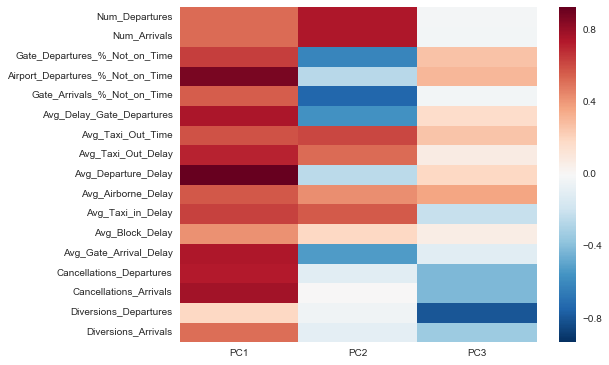

In [26]:
# visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrx.iloc[[0,1,2]].T[3:])

In [27]:
#correlation matrix sorted by PC1
corr_matrx = corr_matrx.iloc[[0,1,2]].T[3:]
corr_matrx.sort_values(by=['PC1'],ascending=0)

,PC1,PC2,PC3
Avg_Departure_Delay,0.926717,-0.247584,0.195038
Airport_Departures_%_Not_on_Time,0.876984,-0.260293,0.310622
Cancellations_Arrivals,0.776860,0.002981,-0.419218
Avg_Delay_Gate_Departures,0.759895,-0.564403,0.168055
Avg_Gate_Arrival_Delay,0.751049,-0.521295,-0.102246
Cancellations_Departures,0.737874,-0.106876,-0.415009
Avg_Taxi_Out_Delay,0.712516,0.526918,0.074765
Gate_Departures_%_Not_on_Time,0.638971,-0.611399,0.274814
Avg_Taxi_in_Delay,0.634186,0.569785,-0.212595
Avg_Taxi_Out_Time,0.591929,0.616025,0.262159


In [28]:
#correlation matrix sorted by PC2
corr_matrx.sort_values(by=['PC2'],ascending=0)

,PC1,PC2,PC3
Num_Departures,0.525091,0.749756,-0.020942
Num_Arrivals,0.526890,0.747520,-0.022063
Avg_Taxi_Out_Time,0.591929,0.616025,0.262159
Avg_Taxi_in_Delay,0.634186,0.569785,-0.212595
Avg_Taxi_Out_Delay,0.712516,0.526918,0.074765
Avg_Airborne_Delay,0.572632,0.427248,0.365514
Avg_Block_Delay,0.426126,0.190875,0.069439
Cancellations_Arrivals,0.776860,0.002981,-0.419218
Diversions_Departures,0.189328,-0.039131,-0.795466
Diversions_Arrivals,0.514996,-0.092758,-0.339423


In [29]:
#correlation matrix sorted by PC2
corr_matrx.sort_values(by=['PC3'],ascending=0)

,PC1,PC2,PC3
Avg_Airborne_Delay,0.572632,0.427248,0.365514
Airport_Departures_%_Not_on_Time,0.876984,-0.260293,0.310622
Gate_Departures_%_Not_on_Time,0.638971,-0.611399,0.274814
Avg_Taxi_Out_Time,0.591929,0.616025,0.262159
Avg_Departure_Delay,0.926717,-0.247584,0.195038
Avg_Delay_Gate_Departures,0.759895,-0.564403,0.168055
Avg_Taxi_Out_Delay,0.712516,0.526918,0.074765
Avg_Block_Delay,0.426126,0.190875,0.069439
Num_Departures,0.525091,0.749756,-0.020942
Gate_Arrivals_%_Not_on_Time,0.563395,-0.735657,-0.021767


### GeoCluster Analysis

In [31]:
# calculate cluster mean
print 'cluster mean', np.mean(df7['cluster'])

# calculate cluster mean by geocluster
df7['geo_cluster'] = geo_cluster
df7.groupby('geo_cluster').cluster.agg(['mean'])

cluster mean 2.19444444444


,mean
geo_cluster,
A,0.000000
B,1.166667
C,1.000000
D,1.500000
E,2.666667
F,2.250000
G,2.555556
H,2.857143
I,3.400000


In [32]:
df7['geo_cluster'] = geo_cluster
pd.pivot_table(df7, index=['geo_cluster', 'shortname'], 
               values=['cluster', 'PC1', 'PC2', 'PC3'])

PC1       PC2       PC3  cluster
geo_cluster shortname                                             
A           ANC-Anchorage   -3.591696  1.909198  1.799370        0
            HNL-Honlu       -5.427066  3.127618  0.544924        0
            OGG-Maui        -6.586943  2.411301 -0.498832        0
B           OAK             -0.750241 -1.774251  1.306455        1
            PDX-PortOr      -4.096619  1.417472  0.158304        0
            SEA             -3.044397  3.396487  0.158675        0
            SFO              4.220641  0.540115 -1.061537        4
            SJC-SanJose     -2.403046 -0.779727  0.407679        1
            SMF-Sac         -2.533590 -0.411678 -0.776836        1
C           BUR-Burbank     -2.541924 -0.631050 -0.623075        1
            LAS-Vegas       -0.457731  0.573157  0.699076        1
            LAX              1.173146  3.058655 -0.412777        2
            LGB-Ca          -4.175712  1.075134 -0.264920        0
            ONT-Ca          -1.120513 -2.181482  1.259452        1
            PHX             -0.940058  2.479815  0.191833        2
            PSP-PalmSpr     -0.726038 -0.570597  0.401180        1
            SAN-SDiego      -1.084243  0.164010 -0.679395        1
            SLC-SaltL       -2.998985  2.548582 -0.711772        0
            SNA-SantaAna    -1.843025 -0.536464 -0.561904        1
            TUS-Az          -2.192800 -1.025470 -1.692252        1
D           ABQ-Albuq       -1.361760 -1.579706 -0.654677        1
            DEN              2.660487  1.341276  0.061559        2
E           AUS-Austin      -1.094623 -1.125419  0.039489        1
            DAL-Love         1.213292 -2.665722  0.819466        5
            DFW-DFtWrth      3.981944  2.930915 -2.829235        4
            HOU-Hobby        1.617995 -2.553056 -0.764575        3
            IAH-HoustonBush  2.695846  1.859338 -1.511273        2
            MCI-KSCity      -0.848567 -0.885105 -1.379197        3
            MSP-Mn          -0.782512  2.374301  1.235107        2
            OMA-Omaha       -0.355496 -1.564438 -1.336558        3
            SAT-SanAntno    -1.425848 -1.066010 -0.124240        1
F           ATL              1.614785  4.745959 -0.854679        2
            BHM-Al          -0.258630 -2.131678 -1.002776        3
            BNA-Nashvl       0.285245 -1.208507 -1.473565        3
            MSY-NewOrleans  -1.470142 -0.853130 -0.852671        1
G           CVG-Ky          -1.551861 -0.411582  0.885010        1
            DAY-Ohio        -0.173761 -1.594271 -0.950553        3
            IND             -0.359557 -1.019268  0.939991        1
            MDW-Chi          5.209569 -1.442290 -1.568390        4
            MEM-Memphis      0.365888 -2.165952  4.069738        5
            MKE-Milw         1.507212 -1.448939 -0.165867        3
            ORD-Ohare        8.949777  2.714989 -1.525406        4
            SDF-Louisvll    -1.093484 -1.221365  2.003398        1
            STL             -0.876017 -1.096091 -0.318506        1
H           FLL-FtLaud       0.844809 -0.322742  0.447105        3
            JAX-Fl          -1.274859 -0.791400 -1.183995        1
            MCO-Orlando      0.782784  0.327507 -1.154469        3
            MIA-Dade         0.419027  1.826180  0.480517        2
            PBI-WPalmB       2.487783 -3.142010  0.141575        5
            RSW-FtMyers     -0.652112 -0.550441 -1.780742        3
            TPA-Tampa       -0.814323 -0.533955 -1.171068        3
I           BDL-Htfd        -1.689290 -0.356440 -0.274213        1
            BOS              0.397235  2.289122 -0.506714        2
            EWR              6.223097  0.951486 -0.137616        4
            HPN-WchNy        5.205093 -4.548098  2.217793        5
            ISP-LiNy         0.129767 -3.767465 -1.790978        3
            JFK              4.811648  2.573254  2.863756        4
            LGA              6.603191  2.696754  0.929214        4
            MH

Each airport's cluster number is plotted by PC1 on the y-axis and PC2 on the x-axis


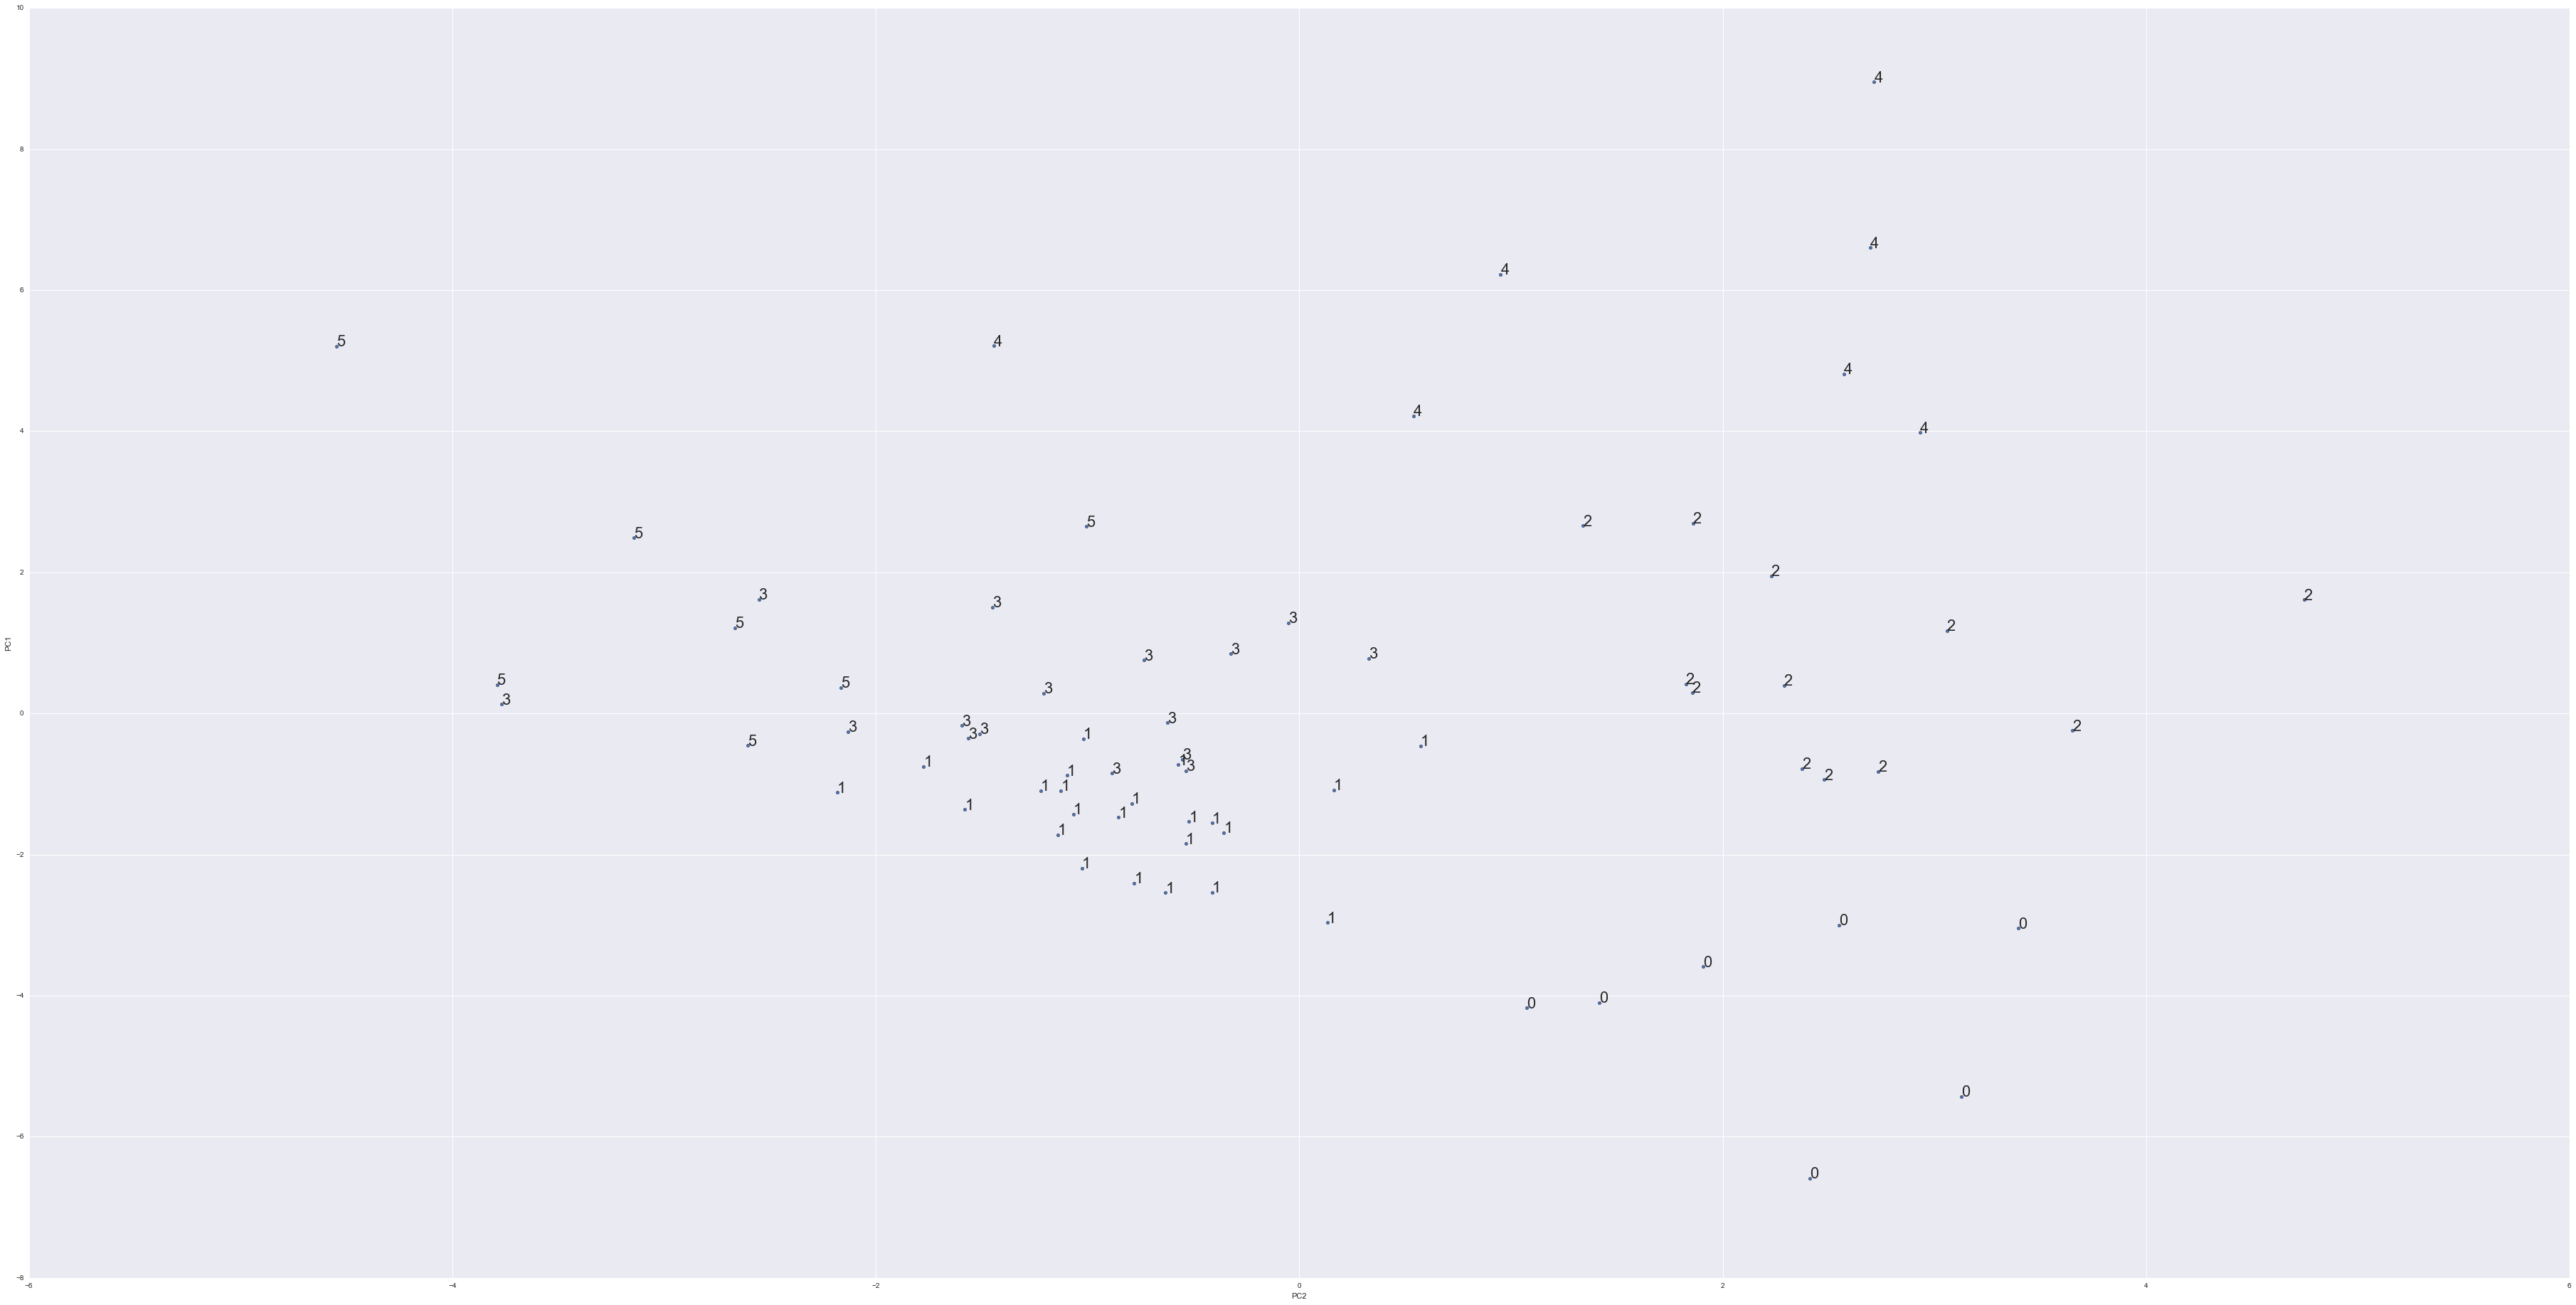

In [37]:
print "Each airport's cluster number is plotted by PC1 on the y-axis and PC2 on the x-axis"
graph = PCdf.plot(kind='scatter', x='PC2', y='PC1', figsize=(64,32))
for i, clustr in enumerate(PCdf['cluster']):
    graph.annotate(clustr, (PCdf.iloc[i].PC2, PCdf.iloc[i].PC1))

Each airport's name is plotted by PC1 on the y-axis and PC2 on the x-axis


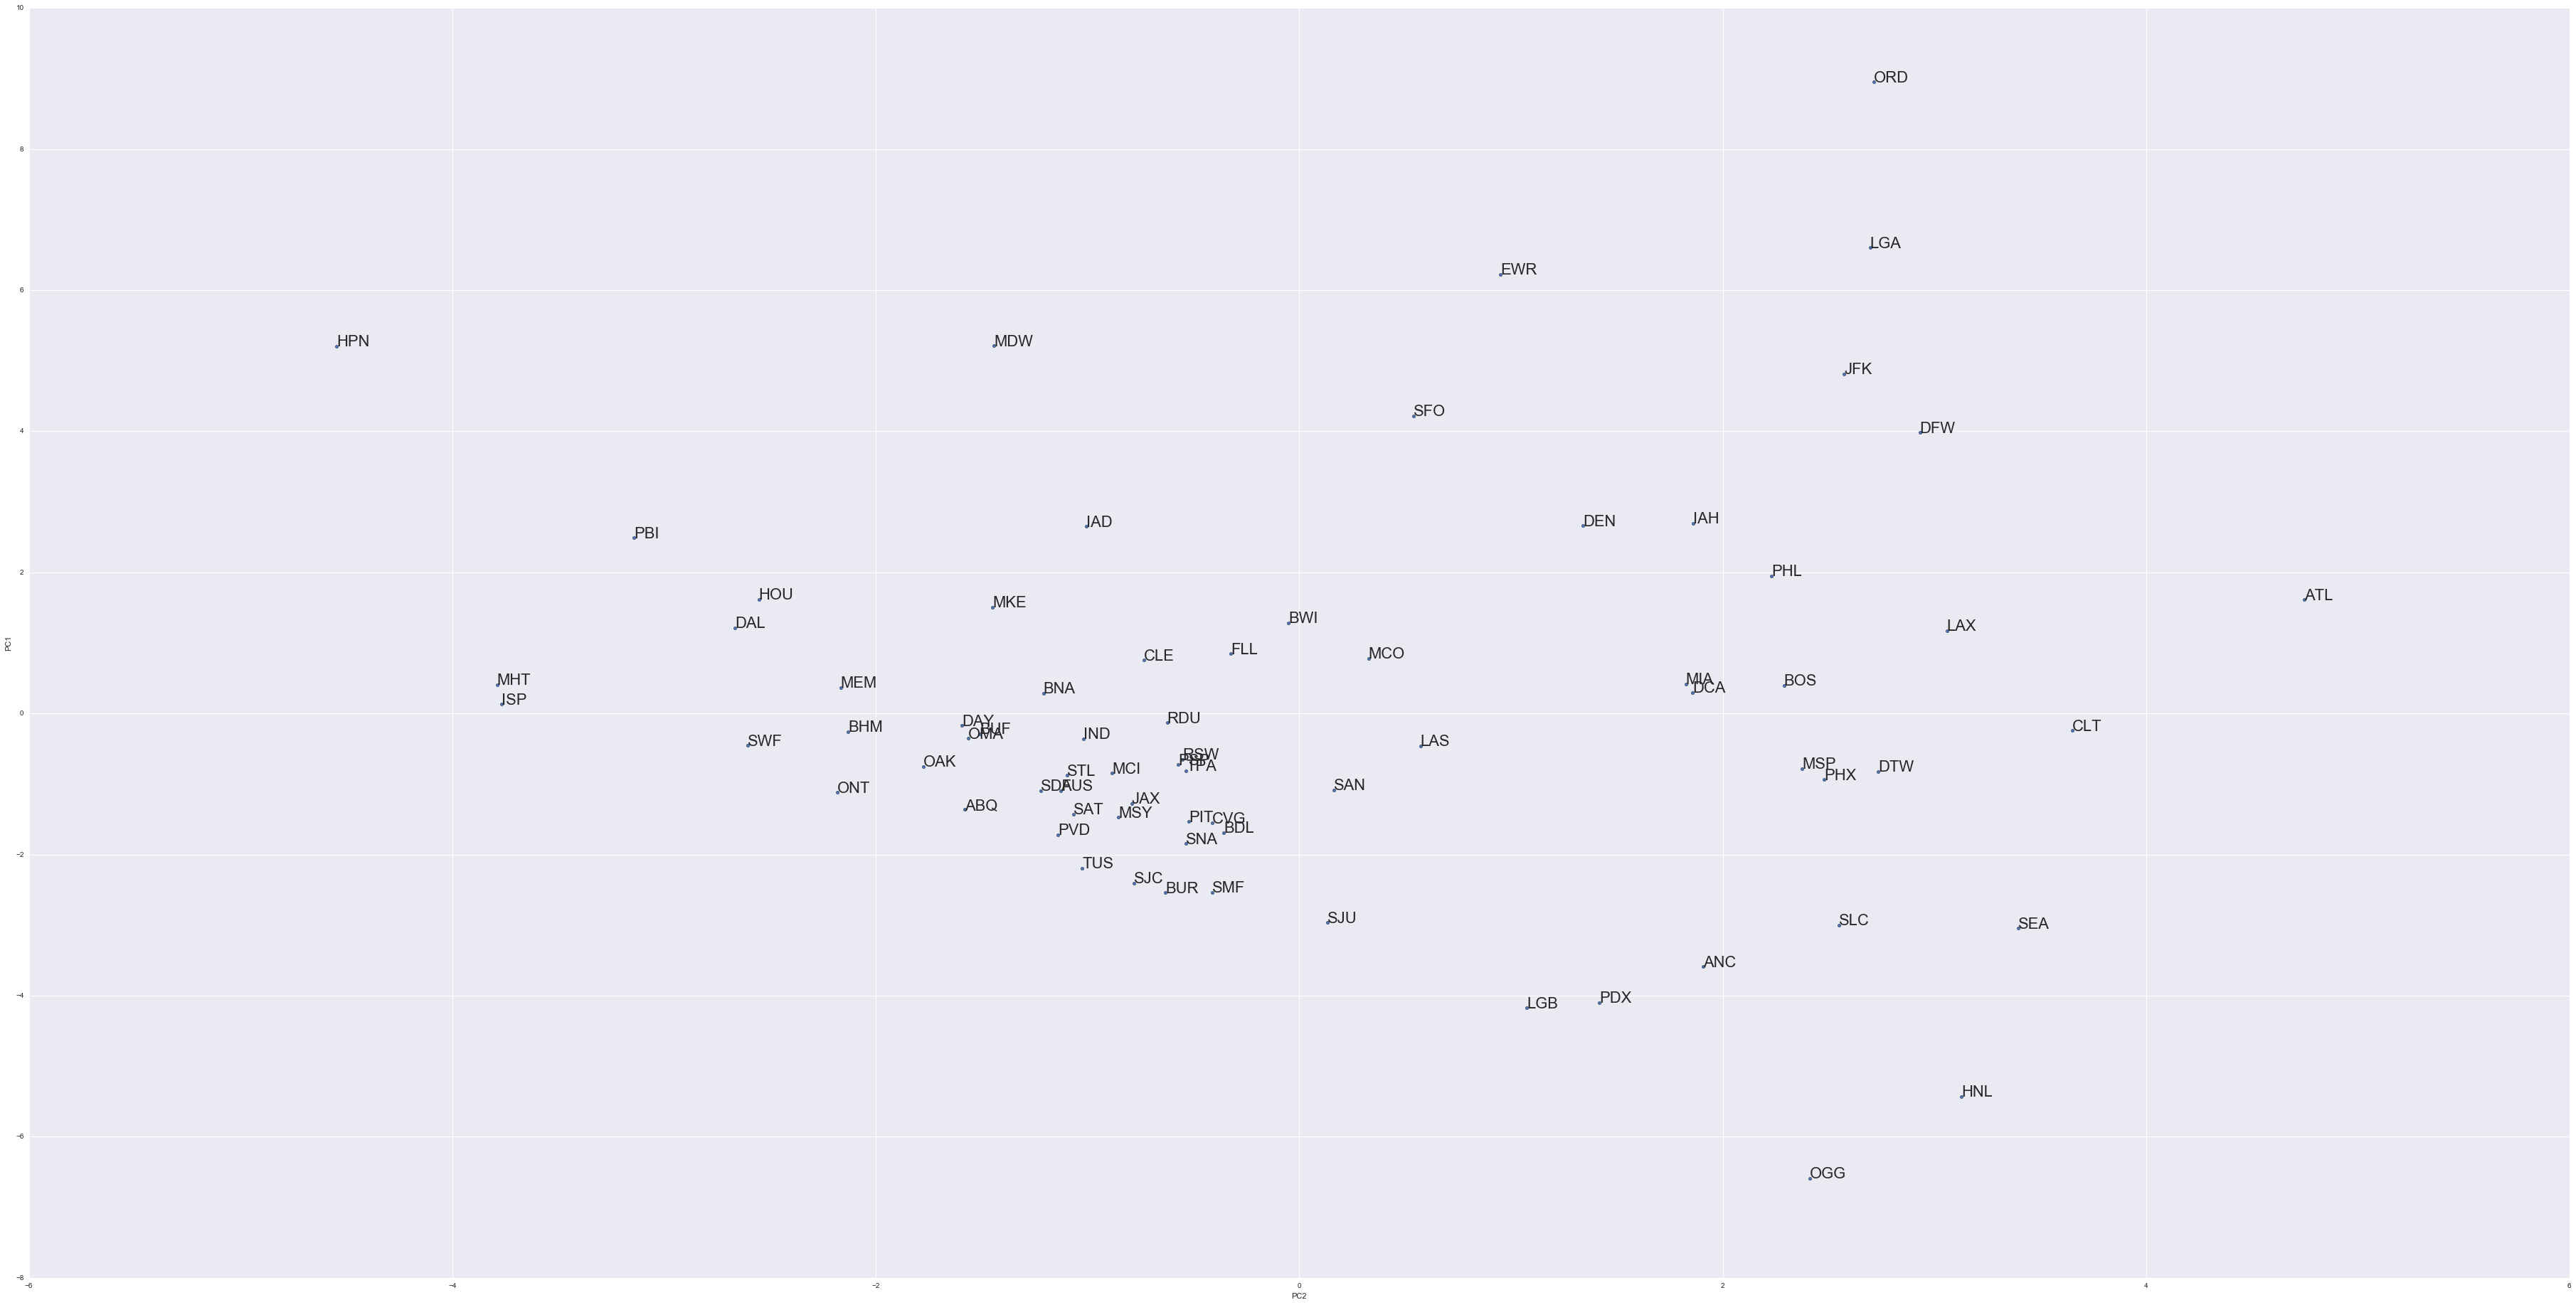

In [38]:
print "Each airport's name is plotted by PC1 on the y-axis and PC2 on the x-axis"
airport = df5['Airport']
PCdf.insert(0, 'airport', airport)      
graph = PCdf.plot(kind='scatter', x='PC2', y='PC1', figsize=(64,32))
for i, airport in enumerate(PCdf['airport']):
    graph.annotate(airport, (PCdf.iloc[i].PC2, PCdf.iloc[i].PC1))

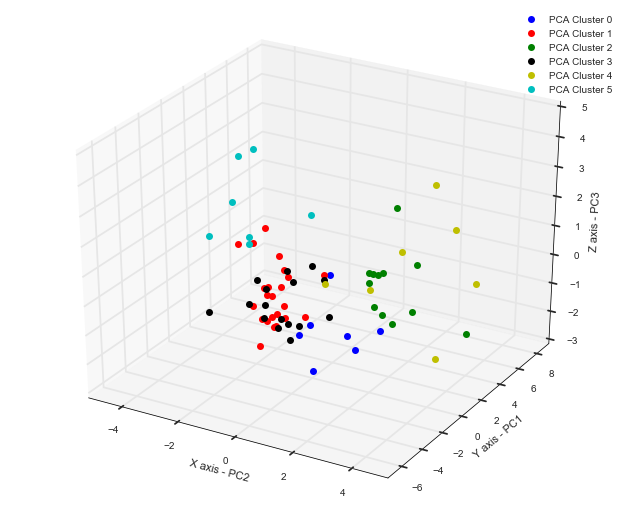

In [45]:
#create lists from dataframe columns
clst, PC1, PC2, PC3 = PCdf['cluster'], PCdf['PC1'], PCdf['PC2'], PCdf['PC3']

#initalize lists for cluster values
clst_0, clst_1, clst_2, clst_3, clst_4, clst_5 = [], [], [], [], [], []

#allocate PC components by cluster 
for i in range(num_airports):
    c = []
    if clst[i] == 0:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_0.append(c)
    elif clst[i] == 1:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_1.append(c)        
    elif clst[i] == 2:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_2.append(c)        
    elif clst[i] == 3:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_3.append(c)        
    elif clst[i] == 4:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_4.append(c)        
    elif clst[i] == 5:
        c.append(PC1[i]); c.append(PC2[i]); c.append(PC3[i])
        clst_5.append(c)        
    else:
        print i, 'check PC clusters'

# convert list of lists to numpy arrays for 3D plotting
c0, c1, c2, c3, c4, c5 = np.array(clst_0), np.array(clst_1), np.array(clst_2),\
np.array(clst_3), np.array(clst_4), np.array(clst_5)

#plot
fig = plt.figure(figsize=(11,9))
ax = fig.add_subplot(111, projection='3d')
ax.plot(c0[:, 1], c0[:, 0], c0[:, 2], 'bo', label='PCA Cluster 0')
ax.plot(c1[:, 1], c1[:, 0], c1[:, 2], 'ro', label='PCA Cluster 1')
ax.plot(c2[:, 1], c2[:, 0], c2[:, 2], 'go', label='PCA Cluster 2')
ax.plot(c3[:, 1], c3[:, 0], c3[:, 2], 'ko', label='PCA Cluster 3')
ax.plot(c4[:, 1], c4[:, 0], c4[:, 2], 'yo', label='PCA Cluster 4')
ax.plot(c5[:, 1], c5[:, 0], c5[:, 2], 'co', label='PCA Cluster 5')
ax.set_ylim3d(-7, 9)
ax.set_xlim3d(-5, 5)
ax.set_zlim3d(-3, 5)
ax.set_xlabel('X axis - PC2')
ax.set_ylabel('Y axis - PC1')
ax.set_zlabel('Z axis - PC3')
ax.legend()
sns.set_style("whitegrid")
plt.show()

This chart is viewed from a different angle in my blog. 